# 資料確認

In [195]:
import json
import pandas as pd
from datetime import datetime

In [196]:
idol_name_sheet = pd.read_excel("K-POP藝人清單.xlsx", sheet_name = "idols")

with open("data/v2-kpop-challenge-shorts.json", 'r', encoding='utf-8') as f:
    youtube_data = json.load(f)    

## 確認是否有重複名稱

In [197]:
# 檢查是否有重複名稱
k_name = idol_name_sheet["name (korean)"].tolist()
k_name_set = set(k_name)

e_name = idol_name_sheet["name (english)"].tolist()
e_name_set = set(e_name)

korean_name_ratio = len(k_name_set) / len(k_name)
english_name_ratio = len(e_name_set) / len(e_name)

print(f"韓文不重複名稱佔比: {korean_name_ratio * 100:.2f}%")
print(f"英文不重複名稱佔比: {english_name_ratio * 100:.2f}%")

韓文不重複名稱佔比: 94.09%
英文不重複名稱佔比: 98.37%


## 確認是否全部的團體都有資料

In [198]:
group_name_list = set(idol_name_sheet["group (english)"].tolist())
youtube_group_name_list = set(youtube_data.keys())

match_group_ratio = len(youtube_group_name_list) / len(group_name_list)

print(f"有資料的團體佔比: {match_group_ratio * 100:.2f}%")
print(f"沒有資料的團體數量: {len(group_name_list) - len(youtube_group_name_list)}")

有資料的團體佔比: 85.33%
沒有資料的團體數量: 11


# 資料處理

## 建立藝人與團體的查找表

In [199]:
group_member_dict = {}

for _, idol in idol_name_sheet.iterrows():
    group_belong_to = idol["group (english)"]

    # 為了方便查找，將團體名稱轉換為小寫
    lower_group_name = group_belong_to.lower()

    # 發現 HashTag 有時會出現只有韓文名稱的狀況，因此需要將韓文名稱也加入查找表
    lower_english_name = idol["name (english)"].lower()
    lower_korean_name = idol['name (korean)'].lower()

    if lower_group_name not in group_member_dict:
        group_member_dict[lower_group_name] = []

    group_member_dict[lower_group_name].append(lower_english_name + "," + lower_korean_name)


with open('group_member.json', 'w', encoding='utf-8') as f:
    json.dump(group_member_dict, f, ensure_ascii=False, indent=4)


print(group_member_dict)

{'ab6ix': ['jeonwoong,전웅', 'kimdonghyun,김동현', 'leedaehwi,이대휘', 'parkwoojin,박우진'], 'aespa': ['giselle,지젤', 'karina,카리나', 'ningning,닝닝', 'winter,윈터'], 'akmu': ['leechanhyuk,이찬혁', 'leesuhyun,이수현'], 'apink': ['bomi,보미', 'chorong,초롱', 'eunji,은지', 'hayoung,하영', 'naeun,나은', 'namjoo,남주'], 'ateez': ['hongjoong,홍중', 'jongho,종호', 'mingi,민기', 'san,산', 'seonghwa,성화', 'wooyoung,우영', 'yeosang,여상', 'yunho,윤호'], 'b1a4': ['baro,바로', 'cnu,신우', 'gongchan,공찬', 'jinyoung,진영', 'sandeul,산들'], 'babymonster': ['ahyeon,아현', 'asa,아사', 'chiquita,치키타', 'pharita,파리타', 'rami,라미', 'rora,로라', 'ruka, 루카'], 'badvillain': ['chloeyoung,클로이영', 'emma,엠마', 'hue,휴이', 'ina,이나', 'kelly,켈리', 'vin,빈', 'yunseo,윤서'], 'bigbang': ['daesung,대성', 'gdragon,지드래곤', 'taeyang,태양'], 'billlie': ['haram,하람', 'haruna,하루나', 'moonsua,문수아', 'sheon,션', 'siyoon,시윤', 'suhyeon,수현', 'tsuki,츠키'], 'boynextdoor': ['jaehyun,명재현', 'leehan,이한', 'riwoo,리우', 'sungho,성호', 'taesan,태산', 'woonhak,운학'], 'btob': ['leechangsub,이창섭', 'leeminhyuk,이민혁', 'limhyunsik,임현식',

## 將影片資訊整理

In [200]:

# 抽取影片中的團體
def getGroupsInVideo(tags):
    groups_in_video = []

    for tag in tags:
        if tag[0] == '#' and (tag[1:] in group_name_list):
            groups_in_video.append(tag[1:].lower())

    return groups_in_video

# 使用團體成員列表查找影片中的合作藝人
def findGroupMember(str, group_members):
    for member in group_members:
        name_split = member.split(",")
        if len(name_split) != 2:
            print(name_split)
            assert False

        english_name,korean_name = name_split
        if str == english_name or str == korean_name:
            return english_name
    return None

# 抽取影片中的合作藝人
def getMembersInVideo(tags, group_list, group_member_dict):
    members_in_video = set()
    for tag in tags:
        for group in group_list:
            member = findGroupMember(tag[1:].lower(), group_member_dict[group])
            if member is not None:
                members_in_video.add((group, member))
    return list(members_in_video)

def get_collaboration_videos(source_group, group_data, group_member_dict):
    collaboration_videos = []

    videos = sorted(group_data['shorts'], key=lambda x: datetime.strptime(x['upload_time'], "%Y-%m-%d %H:%M:%S"))
    
    avg_views =  sum([video['views'] for video in videos]) / len(videos)
    avg_likes =  sum([video['likes'] for video in videos]) / len(videos)
    avg_comments =  sum([video['comments'] for video in videos]) / len(videos)

    for i, video in enumerate(videos):
        print("processing .... ",video['title'])
        tags = video['hashtags']
        groups_in_video = getGroupsInVideo(tags)
        
        members_in_video = getMembersInVideo(tags, groups_in_video, group_member_dict)
            
        is_collaboration = len(members_in_video) < 2
        if is_collaboration:
            print(f"This video is not a collaboration video")
            
        if len(members_in_video) < len(groups_in_video):
            print("Can't find all members in video")
            continue
        collaboration_videos.append({
            "source_group": source_group.lower(),
            "members": members_in_video,
            "type": "single" if is_collaboration else "collaboration",
            "timestamp": datetime.strptime(video['upload_time'], "%Y-%m-%d %H:%M:%S").timestamp(),
            "views": video['views'],
            "likes": video['likes'],
            "comments": video['comments'],
            "avg_views": avg_views,
            "avg_likes": avg_likes,
            "avg_comments": avg_comments,
        })

    print(len(collaboration_videos) / len(group_data['shorts']) * 100, "%")
    return collaboration_videos

In [201]:
collaboration_videos = []
for group in group_name_list:
    if group not in youtube_data:
        print(f"{group} not in data")
        continue
    single_group_videos = get_collaboration_videos(group, youtube_data[group], group_member_dict)
    collaboration_videos.extend(single_group_videos)

collaboration_videos = sorted(collaboration_videos, key=lambda x: x['timestamp'])
import json
with open('collaboration_videos.json', 'w', encoding='utf-8') as f:
    json.dump(collaboration_videos, f, ensure_ascii=False, indent=4)
len(collaboration_videos)

processing ....  (여자)아이들 #TOMBOY_Challenge
This video is not a collaboration video
Can't find all members in video
processing ....  (여자)아이들 #TOMBOY_Challenge #Shorts
processing ....  (여자)아이들 #TOMBOY_Challenge #Shorts
processing ....  (여자)아이들((G)I-DLE) #TOMBOY_Challenge #STAYC #아이사 #윤 #Shorts
processing ....  (여자)아이들((G)I-DLE) #TOMBOY_Challenge #Dreamcatcher #한동 #Shorts
processing ....  (여자)아이들((G)I-DLE) #TOMBOY_Challenge #Jay_park #Shorts
This video is not a collaboration video
processing ....  (여자)아이들((G)I-DLE) #TOMBOY_Challenge #이영지 #Shorts
This video is not a collaboration video
processing ....  (여자)아이들((G)I-DLE) #TOMBOY_Challenge #마마무 #솔라 #Shorts
processing ....  (여자)아이들((G)I-DLE) #TOMBOY_Challenge #Shorts
processing ....  (여자)아이들((G)I-DLE) #TOMBOY_Challenge #Shorts
processing ....  (여자)아이들((G)I-DLE) #TOMBOY_Challenge #Shorts
processing ....  (여자)아이들((G)I-DLE) #TOMBOY_Challenge #Shorts
processing ....  (여자)아이들((G)I-DLE) #TOMBOY_Challenge #아스트로 #산하 #Shorts
processing ....  (여자)아이들((

5311

## 確認合作影片與一般影片的比例

In [202]:
single_group_videos = [video for video in collaboration_videos if video['type'] == 'single']

print(len(single_group_videos) / len(collaboration_videos) * 100, "%")

46.65787987196385 %


## 確認合作影片的觀看趨勢

/var/folders/z8/f3sgj6c57j91g82_1zshpmy40000gn/T/ipykernel_6020/104410032.py:22: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/z8/f3sgj6c57j91g82_1zshpmy40000gn/T/ipykernel_6020/104410032.py:22: UserWarning: Glyph 20316 (\N{CJK UNIFIED IDEOGRAPH-4F5C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/z8/f3sgj6c57j91g82_1zshpmy40000gn/T/ipykernel_6020/104410032.py:22: UserWarning: Glyph 24433 (\N{CJK UNIFIED IDEOGRAPH-5F71}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/z8/f3sgj6c57j91g82_1zshpmy40000gn/T/ipykernel_6020/104410032.py:22: UserWarning: Glyph 29255 (\N{CJK UNIFIED IDEOGRAPH-7247}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/z8/f3sgj6c57j91g82_1zshpmy40000gn/T/ipykernel_6020/104410032.py:22: UserWarning: Glyph 20114 (\N{CJK UNIFIED IDEOGRAPH-4E92}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/z8/f3sgj6c57j91g8

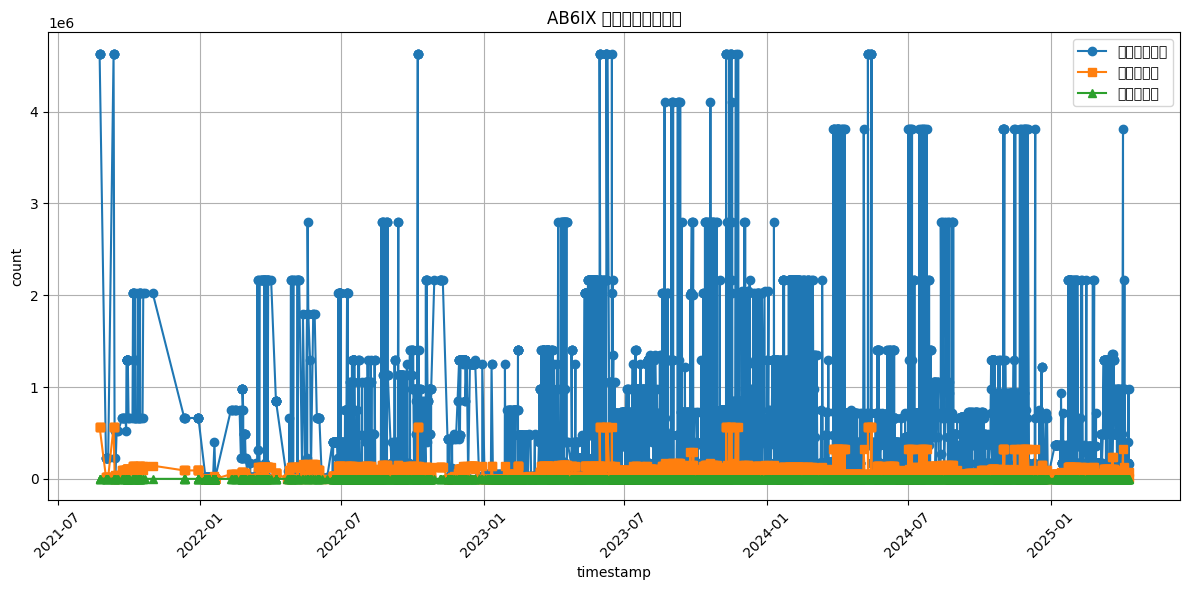

In [ ]:
import matplotlib.pyplot as plt
import datetime

collaboration_videos

timestamps = [datetime.datetime.fromtimestamp(video['timestamp']) for video in collaboration_videos]
views = [video['views'] for video in collaboration_videos]
likes = [video['likes'] for video in collaboration_videos]
comments = [video['comments'] for video in collaboration_videos]

plt.figure(figsize=(12, 6))
plt.plot(timestamps, views, label='平均觀看次數', marker='o')
plt.plot(timestamps, likes, label='平均按讚數', marker='s')
plt.plot(timestamps, comments, label='平均留言數', marker='^')

plt.title('AB6IX 合作影片互動趨勢')
plt.xlabel('timestamp')
plt.ylabel('count')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [204]:
def getEventGraphEdge(event):
    event_edges = []
    members = event['members']
    
    groups = set()
    for group, _ in members:
        groups.add(group)

    if(len(groups) == 1):
        for i in range(len(members)):
            for j in range(i+1,len(members)):
                u_group, u_idol = members[i]
                v_group, v_idol = members[j]

                event_edges.append([
                    f"{u_group},{u_idol}",f"{v_group},{v_idol}"
                ])
                event_edges.append([
                    f"{v_group},{v_idol}",f"{u_group},{u_idol}"
                ])

        return event_edges
    else:
        source_group = event['source_group']

        for i in range(len(members)):
            for j in range(i+1,len(members)):
                u_group, u_idol = members[i]
                v_group, v_idol = members[j]

                new_edge = []
                if(u_group == source_group):
                    new_edge = [f"{u_group},{u_idol}",f"{v_group},{v_idol}"]
                else:
                    new_edge = [f"{v_group},{v_idol}",f"{u_group},{u_idol}"]
                event_edges.append(new_edge)
                    
        return event_edges

In [205]:
import networkx as nx
from pyvis.network import Network
from collections import Counter

G = nx.DiGraph()
graph_edges = []
for video in collaboration_videos: 
    graph_edges.extend(getEventGraphEdge(video))
G.add_edges_from(graph_edges)

# 合作次數
# 統計每對節點間的總邊數
edge_counter = Counter()
for u, v in G.edges():
    edge_counter[(u, v)] += 1
net = Network(notebook=True)

# 讓圖動起來(靜態會很亂)
net.toggle_physics(True)
net.set_options("""
{
  "physics": {
    "enabled": true,
    "solver": "forceAtlas2Based",
    "forceAtlas2Based": {
      "gravitationalConstant": -100,
      "centralGravity": 0.01,
      "springLength": 150,
      "springConstant": 0.02,
      "damping": 0.8,
      "avoidOverlap": 1
    },
    "minVelocity": 0.75,
    "stabilization": {
      "iterations": 150,
      "updateInterval": 25
    }
  }
}
""")

# 加入節點
for node in G.nodes():
    group, idol = node.split(",")
    net.add_node(
        node,
        group = group,
        label= idol,
        font={'size': 12, 'vadjust': -40}
    )

# 加入邊（只加一次每對邊(合作組合)，並顯示合作次數）
for (u, v), count in edge_counter.items():
    net.add_edge(
        u, v,
        label=str(count),  # 顯示合作次數
        color='rgba(0,0,0,0.5)',
        arrowStrikethrough=False,
        title=f"{u} - {v} has {count} edges",
        width=2
    )

#net.show_buttons()
# net.show("cooperation.html")
net.save_graph("cooperation.html")

In [206]:
graph_snap_shot = []

node_set = set()

for video in collaboration_videos:
    for group, idol in video['members']:
        node_set.add(f"{group},{idol}")

G = nx.DiGraph()
G.add_nodes_from(node_set)

sorted_collaboration_videos = sorted(collaboration_videos, key=lambda x: x['timestamp'])

graph_snap_shot.append(G.copy())
for i in range(len(sorted_collaboration_videos)):
    graph_snap_shot.append(graph_snap_shot[-1].copy())
    event_edges = getEventGraphEdge(sorted_collaboration_videos[i])
    for event_edge in event_edges:
        if graph_snap_shot[-1].has_edge(event_edge[0], event_edge[1]):
            # 如果邊已存在，增加權重
            graph_snap_shot[-1][event_edge[0]][event_edge[1]]['weight'] += 1
        else:
            # 如果邊不存在，設置初始權重為1
            graph_snap_shot[-1].add_edge(event_edge[0], event_edge[1], weight=1)
            

In [207]:
test_set = graph_snap_shot[2266:]


top_k_score = []


for i in range(len(test_set)):
    G = test_set[i]

    jaccard_scores = list(nx.jaccard_coefficient(G))
    adamic_adar_scores = list(nx.adamic_adar_index(G))
    shortest_path_list = []
    for u, v in G.edges():
        shortest_path_list.append(nx.shortest_path_length(G, u, v))


    # 計算前1%的閾值
    jaccard_threshold = sorted([score[2] for score in jaccard_scores], reverse=True)[int(len(jaccard_scores) * 0.01)]
    adamic_threshold = sorted([score[2] for score in adamic_adar_scores], reverse=True)[int(len(adamic_adar_scores) * 0.01)]
    shortest_path_threshold = sorted(shortest_path_list, reverse=False)[int(len(shortest_path_list) * 0.01)]

    # 獲取前1%的節點對
    top_jaccard = {(u, v) for u, v, score in jaccard_scores if score >= jaccard_threshold}
    top_adamic = {(u, v) for u, v, score in adamic_adar_scores if score >= adamic_threshold}
    top_shortest_path = {(u, v) for u, v in G.edges() if nx.shortest_path_length(G, u, v) <= shortest_path_threshold}
    # 取交集
    intersection = top_jaccard & top_adamic & top_shortest_path
 
    

    




NetworkXNotImplemented: not implemented for directed type